In [1]:
from matplotlib import pyplot as plt
import numpy as np
from time import time
from os.path import abspath, join
import sys
from glob import glob
import vaex
from hammer import mond
root_dir = abspath(join('..', '..'))
data_dir = join(root_dir, 'Data')
sys.path.append(root_dir)
from utils import (plot_corner, plot_chain, plot_fit, style, calculate_probs, get_params, get_initial_position_normal)

In [2]:
style()

In [3]:
zfiles = glob(join(root_dir, 'Data', 'Effective-Volume-no', 'z*.hdf5'))
zfiles.sort()
wfiles = glob(join(root_dir, 'Data', 'Velocity-Distribution-no', 'w*.hdf5'))
wfiles.sort()
zfiles, wfiles

(['/home2/s20321005/Thesis-Project/Data/Effective-Volume-no/z_(-0.10)_(0.10).hdf5',
  '/home2/s20321005/Thesis-Project/Data/Effective-Volume-no/z_(0.10)_(0.16).hdf5',
  '/home2/s20321005/Thesis-Project/Data/Effective-Volume-no/z_(0.16)_(0.20).hdf5',
  '/home2/s20321005/Thesis-Project/Data/Effective-Volume-no/z_(0.20)_(0.23).hdf5',
  '/home2/s20321005/Thesis-Project/Data/Effective-Volume-no/z_(0.23)_(0.26).hdf5',
  '/home2/s20321005/Thesis-Project/Data/Effective-Volume-no/z_(0.26)_(0.28).hdf5',
  '/home2/s20321005/Thesis-Project/Data/Effective-Volume-no/z_(0.28)_(0.30).hdf5',
  '/home2/s20321005/Thesis-Project/Data/Effective-Volume-no/z_(0.30)_(0.32).hdf5',
  '/home2/s20321005/Thesis-Project/Data/Effective-Volume-no/z_(0.32)_(0.34).hdf5',
  '/home2/s20321005/Thesis-Project/Data/Effective-Volume-no/z_(0.34)_(0.36).hdf5',
  '/home2/s20321005/Thesis-Project/Data/Effective-Volume-no/z_(0.36)_(0.37).hdf5',
  '/home2/s20321005/Thesis-Project/Data/Effective-Volume-no/z_(0.37)_(0.39).hdf5',
  '

In [4]:
index = 0
zfile = zfiles[index]
wfile = wfiles[index]
zdata = vaex.open(zfile)
zmid = zdata['zmid'].to_numpy()
znum = zdata['znum'].to_numpy()
zerr = zdata['zerr'].to_numpy()

wdata = vaex.open(wfile)
wmid = wdata['wmid'].to_numpy()
wnum = wdata['wnum'].to_numpy()
werr = wdata['werr'].to_numpy()

zdata = (zmid, znum, zerr)
wdata = (wmid, wnum, werr)

In [5]:
# Baryonic density, check table 1 from this https://journals.aps.org/prl/pdf/10.1103/PhysRevLett.121.081101
rhob = [
    0.0104, 0.0277, 0.0073, 0.0005, 0.0006, 0.0018,
    0.0018, 0.0029, 0.0072, 0.0216, 0.0056, 0.0015
]
sigmaz = [
    3.7, 7.1, 22.1, 39.0, 15.5, 7.5, 12.0, 
    18.0, 18.5, 18.5, 20.0, 20.0]
mu0 = [0.5]
log_nu0 = [0.]
R = [3.4E-3]
zsun = [30]
w0 = [-7.]
sigma1 = 5.
sigma2 = 10.
log_sigmaw = [np.log(sigma1)]
q_sigmaw = [sigma1/sigma2]
a1 = 0.9
a2 = 0.1
log_a = [np.log(a1)]
q_a = [a2/a1]

theta = np.array([rhob + sigmaz + mu0 + log_nu0 + R + zsun + w0 + log_sigmaw + q_sigmaw + log_a + q_a]).flatten()
theta.shape

(33,)

In [6]:
locs_raw = dict(
    mu0=0.1,
    log_nu0=-1,
    R=3.4E-3,
    zsun=-100,
    w0=-15,
    log_sigmaw=np.log(1),
    q_sigmaw=0.,
    log_a=np.log(0.01),
    q_a=0.,
)

scales_raw = dict(
    mu0=5.9,
    log_nu0=3,
    R=0.6E-3,
    zsun=200,
    w0=15,
    log_sigmaw=np.log(50)-locs_raw['log_sigmaw'],
    q_sigmaw=1.,
    log_a=np.log(100)-locs_raw['log_a'],
    q_a=1.0
)

keys = list(locs_raw.keys())
locs = np.array(list(locs_raw.values()))
scales = np.array(list(scales_raw.values()))

[(k, loc, th, s+loc) for k, loc, th, s in zip(keys, locs, theta[24:], scales)]

[('mu0', 0.1, 0.5, 6.0),
 ('log_nu0', -1.0, 0.0, 2.0),
 ('R', 0.0034, 0.0034, 0.004),
 ('zsun', -100.0, 30.0, 100.0),
 ('w0', -15.0, -7.0, 0.0),
 ('log_sigmaw', 0.0, 1.6094379124341003, 3.912023005428146),
 ('q_sigmaw', 0.0, 0.5, 1.0),
 ('log_a', -4.605170185988091, -0.10536051565782628, 4.605170185988093),
 ('q_a', 0.0, 0.11111111111111112, 1.0)]

In [7]:
ndim = len(locs)+24
nwalkers = 10*ndim+2
ndim, nwalkers

(33, 332)

In [8]:
p0 = mond.generate_p0(nwalkers, locs, scales)
p0.shape

(332, 33)

In [9]:
for p in p0:
    print(mond.log_prob(p, zdata, wdata, locs, scales))

(31.77303295907402, -6170.014845633319)
(38.28261720958918, -13672790.532775586)
(40.31707745380022, -38938.03960100596)
(44.47048423926915, -3426920.0228235302)
(43.92160395605962, -32184.68613583512)
(43.96682270121259, -132913.72054603262)
(41.96781020040166, -12325.749427972474)
(42.31300374989071, -202814.1632432381)
(45.99128080033798, -633.6306738883229)
(39.325406055265184, -25552.463427863073)
(30.293623251562163, -1001.8443644681452)
(46.26498158191042, -2830188.218098977)
(41.138796239493516, -624.0646848313277)
(42.84265441937655, -31363.993749417885)
(39.67930475741491, -2486.147591331608)
(45.334000954621736, -1243.9245151733523)
(40.73596415586628, -18962.16904851708)
(43.01783224245402, -961478.4608222035)
(42.37526402549668, -1174089797.2646413)
(39.755630393133536, -1014165.3894828464)
(35.343275868865504, -147611.9222035795)
(41.22956734691317, -11405.188118931692)
(44.02719420848872, -1207.8619081010052)
(40.22366502575507, -29185.95298170603)
(42.84648774543601, -1

In [10]:
p0_flat = p0.reshape(-1, ndim)
mond.log_prob_par(p0_flat, zdata, wdata, locs, scales)

array([[ 3.17730330e+01, -6.20178788e+03, -6.17001485e+03],
       [ 3.82826172e+01, -1.36728288e+07, -1.36727905e+07],
       [ 4.03170775e+01, -3.89783567e+04, -3.89380396e+04],
       [ 4.44704842e+01, -3.42696449e+06, -3.42692002e+06],
       [ 4.39216040e+01, -3.22286077e+04, -3.21846861e+04],
       [ 4.39668227e+01, -1.32957687e+05, -1.32913721e+05],
       [ 4.19678102e+01, -1.23677172e+04, -1.23257494e+04],
       [ 4.23130037e+01, -2.02856476e+05, -2.02814163e+05],
       [ 4.59912808e+01, -6.79621955e+02, -6.33630674e+02],
       [ 3.93254061e+01, -2.55917888e+04, -2.55524634e+04],
       [ 3.02936233e+01, -1.03213799e+03, -1.00184436e+03],
       [ 4.62649816e+01, -2.83023448e+06, -2.83018822e+06],
       [ 4.11387962e+01, -6.65203481e+02, -6.24064685e+02],
       [ 4.28426544e+01, -3.14068364e+04, -3.13639937e+04],
       [ 3.96793048e+01, -2.52582690e+03, -2.48614759e+03],
       [ 4.53340010e+01, -1.28925852e+03, -1.24392452e+03],
       [ 4.07359642e+01, -1.90029050e+04

(33,)


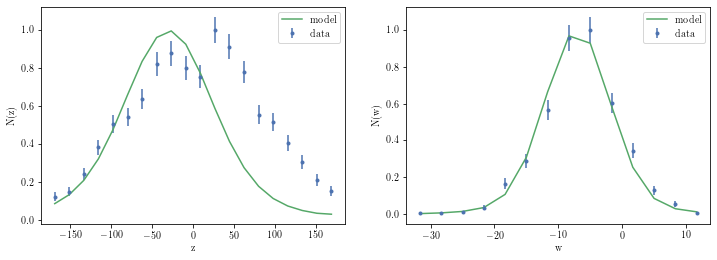

(53.52757808220316, -125.00553935776695)

In [11]:
print(theta.shape)
zmod = mond.fz(zmid, theta)
wmod = mond.fw(wmid, theta)

# plot
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].errorbar(zmid, znum, yerr=zerr, fmt='.', label='data')
ax[0].plot(zmid, zmod, label='model')
ax[0].set_xlabel('z')
ax[0].set_ylabel('N(z)')
ax[0].legend()
ax[1].errorbar(wmid, wnum, yerr=werr, fmt='.', label='data')
ax[1].plot(wmid, wmod, label='model')
ax[1].set_xlabel('w')
ax[1].set_ylabel('N(w)')
ax[1].legend()
plt.show()
mond.log_prob(theta, zdata, wdata, locs, scales)

In [12]:
time0 = time()
for i in range(5):
    print("\t",i)
    t0 = time()
    chain = mond.mcmc(500, nwalkers, p0, zdata, wdata, locs, scales, dz=1, verbose=True, parallel=True)
    print(time() - t0, "s")
    burn = 300
    keys, locs_normal, scales_normal = get_initial_position_normal(keys, chain[burn:], np.arange(24, 24+len(keys)))
    p0 = mond.generate_p0(nwalkers, locs_normal, scales_normal, norm=True)
    t0 = time()
    chain = mond.mcmc(500, nwalkers, p0, zdata, wdata, locs, scales, dz=1, verbose=True, parallel=True)
    print(time() - t0, "s")
    p0 = chain[-1]
print("total", time() - time0, "s")

	 0
13.757007122039795 s
12.32494330406189 s
	 1
12.41652774810791 s
12.554458379745483 s
	 2
12.453890800476074 s
12.595645904541016 s
	 3
12.58117127418518 s
12.553034543991089 s
	 4
12.505815267562866 s
12.539472341537476 s
total 126.44196677207947 s


In [13]:
calculate_probs(mond, chain, ndim, zdata, wdata, locs, scales, batch=100)

array([[ 41.42249098, -38.54687905,   2.87561193],
       [ 39.68176082,  29.22266675,  68.90442756],
       [ 37.58442215,  34.09335051,  71.67777266],
       ...,
       [ 42.68146137,  63.9548122 , 106.63627357],
       [ 31.56288811,  60.08367595,  91.64656407],
       [ 43.93494486,  65.48763911, 109.42258398]])

10it [00:01,  7.02it/s]


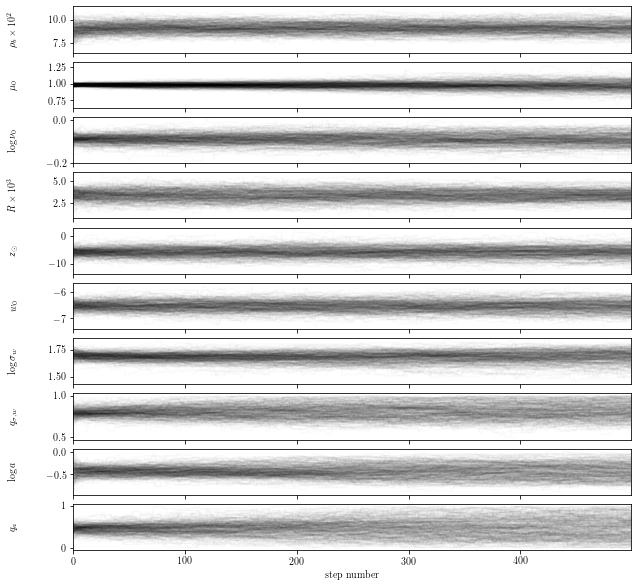

In [14]:
labels = [r'$\rho_b\times 10^2$', r'$\mu_0$' ,r'$\log \nu_0$', 
          r'$R\times 10^3$', r'$z_{\odot}$', r'$w_0$', 
          r'$\log \sigma_{w}$', r'$q_{\sigma,w}$', r'$\log a$', r'$q_a$']
labs = ['rhob', 'mu0', 'log_nu0', 'R', 'zsun', 'w0', 'log_sigmaw', 'q_sigmaw', 'log_a', 'q_a']
indexes = [12] + list(range(24, len(labs)+23))

params = get_params(chain, indexes, labs)
plot_chain(params, labels, figsize=(10,10), alpha=0.02)

In [15]:
p0_next = chain[-1, :, :]
t0 = time()
chain = mond.mcmc(2000, nwalkers, p0_next, zdata, wdata, locs, scales, dz=1, verbose=True, parallel=True)
print(time() - t0, "s")
chain.shape

50.09669518470764 s


(2000, 332, 33)

10it [00:01,  7.41it/s]


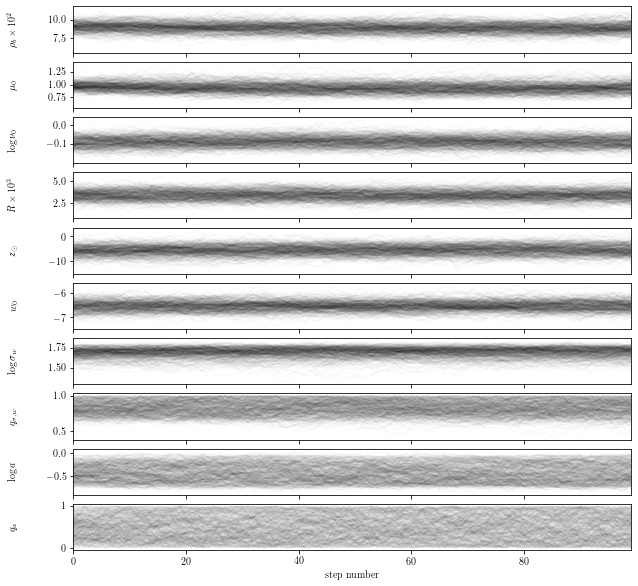

In [16]:
thin = 20
labels = [r'$\rho_b\times 10^2$', r'$\mu_0$' ,r'$\log \nu_0$', 
          r'$R\times 10^3$', r'$z_{\odot}$', r'$w_0$', 
          r'$\log \sigma_{w}$', r'$q_{\sigma,w}$', r'$\log a$', r'$q_a$']
labs = ['rhob', 'mu0', 'log_nu0', 'R', 'zsun', 'w0', 'log_sigmaw', 'q_sigmaw', 'log_a', 'q_a']
indexes = [12] + list(range(24, len(labs)+23))
chain_thin = chain[::thin]

params = get_params(chain_thin, indexes, labs)
plot_chain(params, labels, figsize=(10,10), alpha=0.02)

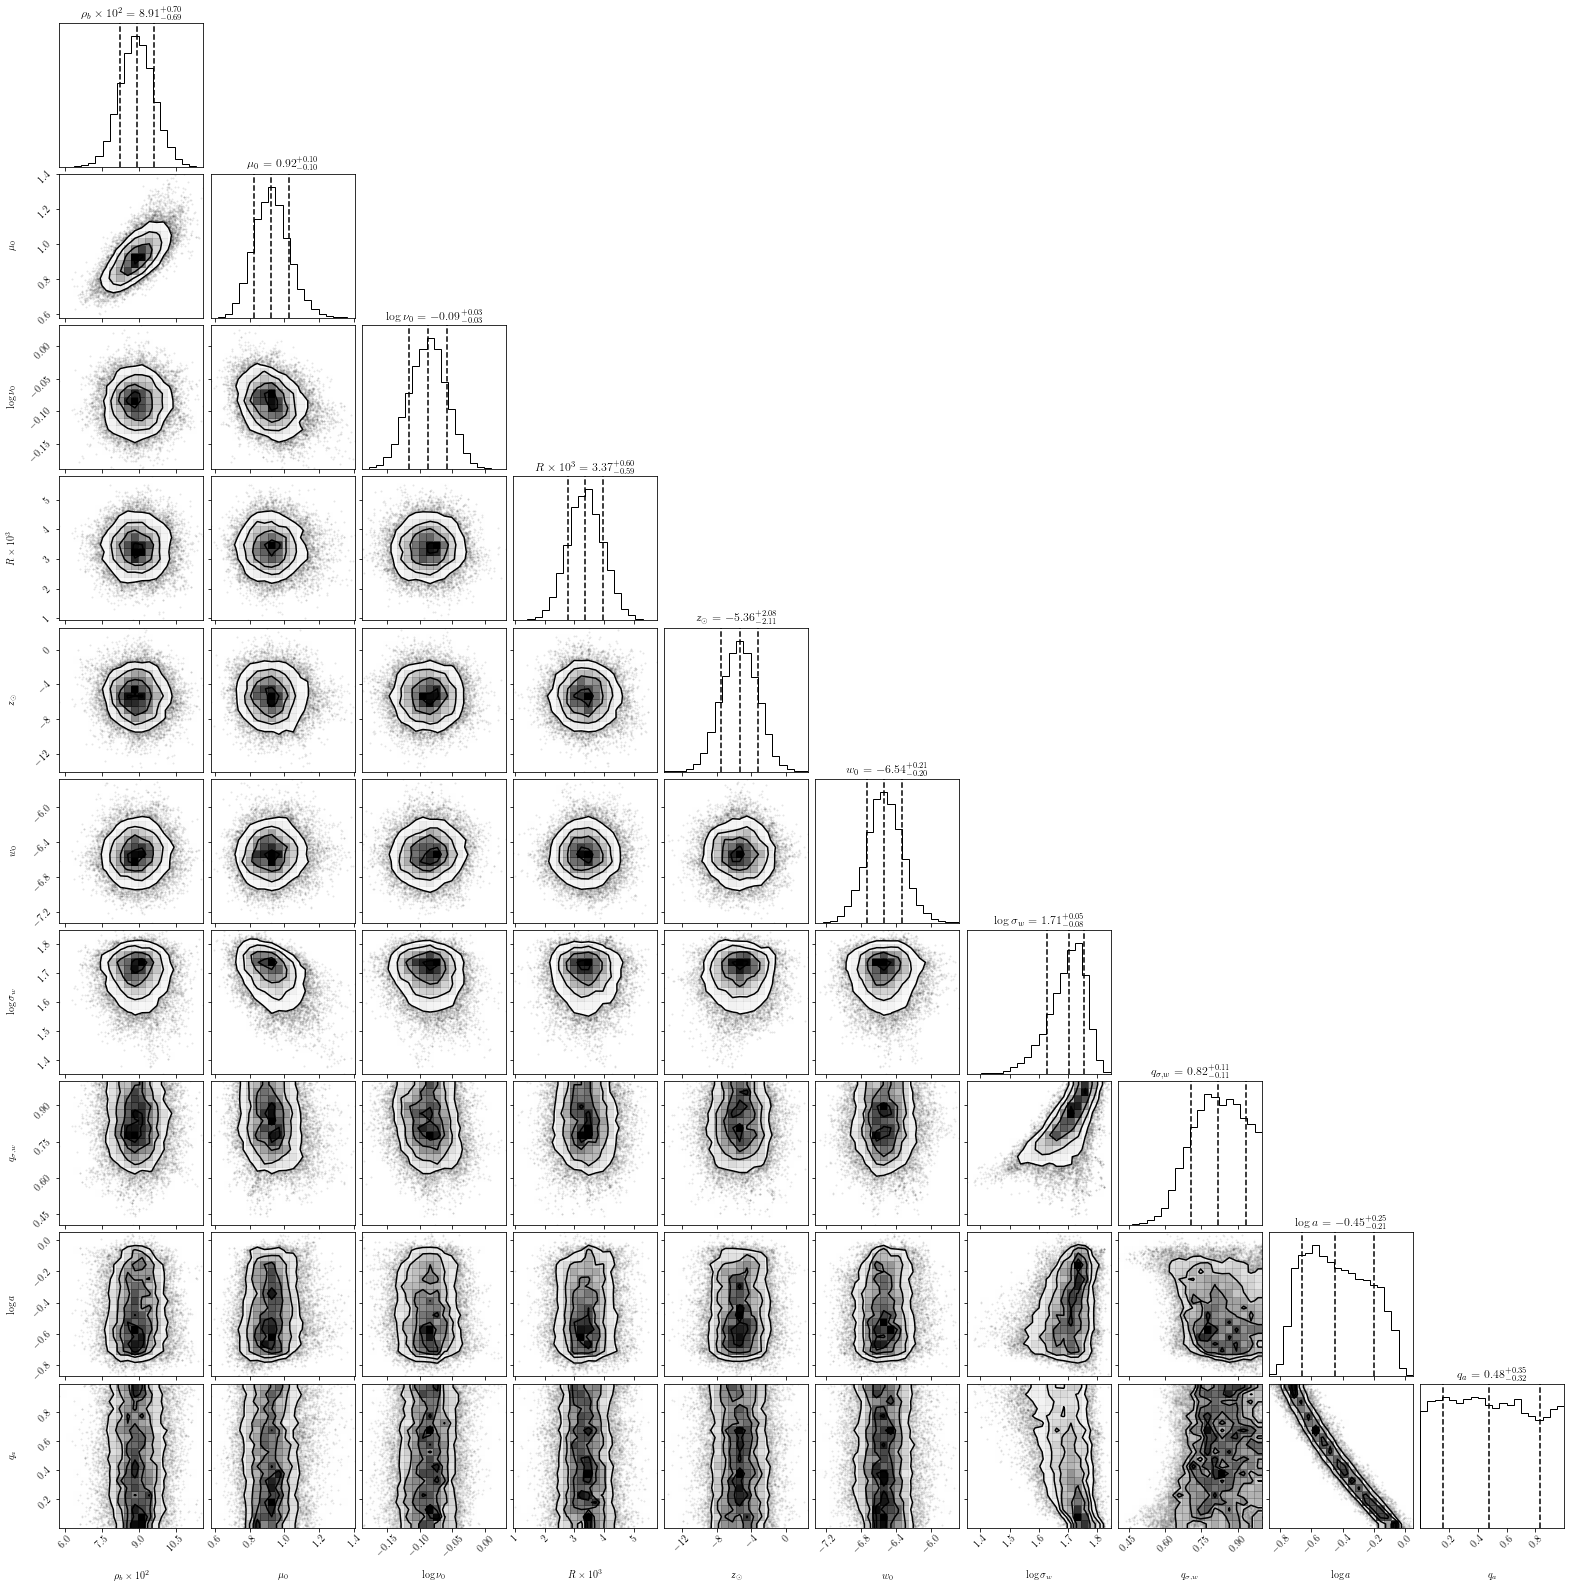

In [17]:
labels = [r'$\rho_b\times 10^2$', r'$\mu_0$' ,r'$\log \nu_0$', 
          r'$R\times 10^3$', r'$z_{\odot}$', r'$w_0$', 
          r'$\log \sigma_{w}$', r'$q_{\sigma,w}$', r'$\log a$', r'$q_a$']
labs = ['rhob', 'mu0', 'log_nu0', 'R', 'zsun', 'w0', 'log_sigmaw', 'q_sigmaw', 'log_a', 'q_a']
indexes = [12] + list(range(24, len(labs)+23))
chain_thin = chain[::thin]

params = get_params(chain_thin[40:], indexes, labs)
plot_corner(params, labels)

(664000, 33)


100%|██████████| 5000/5000 [00:03<00:00, 1630.75it/s]


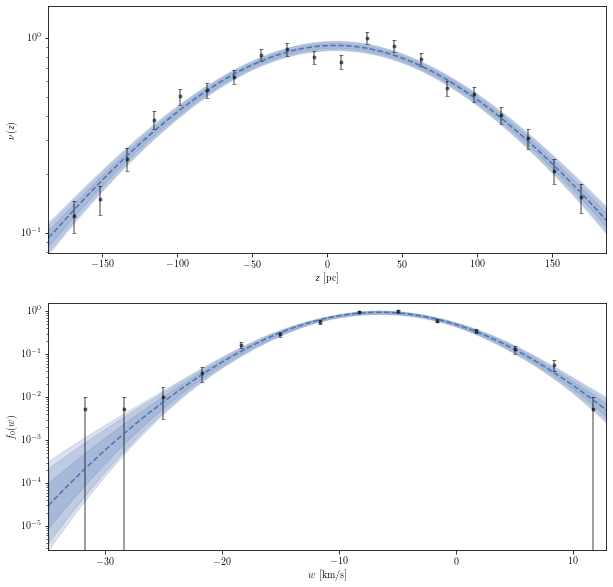

In [18]:
plot_fit(mond, zdata, wdata, chain, ndim)

In [23]:
probs = calculate_probs(mond, chain, ndim, zdata, wdata, locs, scales)

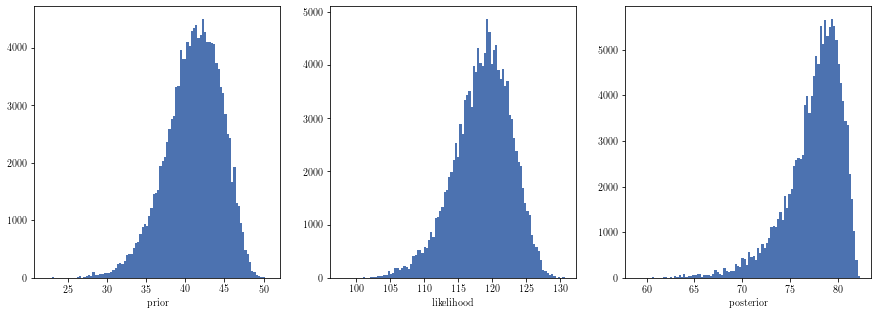

130.66268262177257

In [24]:
prior = probs[:, 0]
likelihood = probs[:, 2]
posterior = probs[:, 1]
# plot histogram of probabilities
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].hist(prior, bins=100)
axes[0].set_xlabel('prior')
axes[1].hist(likelihood, bins=100)
axes[1].set_xlabel('likelihood')
axes[2].hist(posterior, bins=100)
axes[2].set_xlabel('posterior')
plt.show()
likelihood.max()

# educated initial guess!?!

check 1_mock_dm

# Script

do mcmc for

* same $N$, different $z$
* same $z$, different $N$

Each 'running' contains
1. generate_init: initial position for walkers.
    * this is done by the experiment above.
2. run_mcmc: run true mcmc for 10_000 steps.
3. plot trace: plot trace plot for preliminary mcmc.
4. plot corner: plot corner plot for the long run.
5. plot fit: fitting plot for vertical density and vertical dispersion.
6. calculate bic & aic: calculate bic and aic for the long run.

All of these functionalities are implemented in `mcmc.py` at `utils`.

Just run the `program.py` at `script`.
To automate the process for all data, run `run_program.py` at `script`.

# Mock comparison

run mcmc but now for mock data comparison.

`Data/MCMC/dm_mock/mock/comp`

It contains mock data with different number of data points.
1000, 5000, 10000, 20000, 50000, 100000, 200000, 500000, 1000000

This comparison is done to see the prediction power of the model.

In [25]:
from matplotlib import pyplot as plt
import numpy as np
from time import time
from os.path import abspath, join
import sys
from glob import glob
import vaex
from hammer import mond
root_dir = abspath(join('..', '..'))
data_dir = join(root_dir, 'Data')
sys.path.append(root_dir)

In [26]:
from utils import style, calculate_probs, plot_chain, plot_corner, plot_fit, get_params

style()

In [27]:
zfiles = glob(join(root_dir, 'Data', 'MCMC', 'dm_mock', 'mock', 'comp', 'z*.hdf5'))
zfiles.sort()
wfiles = glob(join(root_dir, 'Data', 'MCMC', 'dm_mock', 'mock', 'comp','w*.hdf5'))
wfiles.sort()
zfiles, wfiles

(['/home2/s20321005/Thesis-Project/Data/MCMC/dm_mock/mock/comp/z_1000.hdf5',
  '/home2/s20321005/Thesis-Project/Data/MCMC/dm_mock/mock/comp/z_10000.hdf5',
  '/home2/s20321005/Thesis-Project/Data/MCMC/dm_mock/mock/comp/z_100000.hdf5',
  '/home2/s20321005/Thesis-Project/Data/MCMC/dm_mock/mock/comp/z_1000000.hdf5',
  '/home2/s20321005/Thesis-Project/Data/MCMC/dm_mock/mock/comp/z_5000.hdf5',
  '/home2/s20321005/Thesis-Project/Data/MCMC/dm_mock/mock/comp/z_50000.hdf5',
  '/home2/s20321005/Thesis-Project/Data/MCMC/dm_mock/mock/comp/z_500000.hdf5'],
 ['/home2/s20321005/Thesis-Project/Data/MCMC/dm_mock/mock/comp/w_1000.hdf5',
  '/home2/s20321005/Thesis-Project/Data/MCMC/dm_mock/mock/comp/w_10000.hdf5',
  '/home2/s20321005/Thesis-Project/Data/MCMC/dm_mock/mock/comp/w_100000.hdf5',
  '/home2/s20321005/Thesis-Project/Data/MCMC/dm_mock/mock/comp/w_1000000.hdf5',
  '/home2/s20321005/Thesis-Project/Data/MCMC/dm_mock/mock/comp/w_5000.hdf5',
  '/home2/s20321005/Thesis-Project/Data/MCMC/dm_mock/mock/co

In [28]:
index = 0
zfile = zfiles[index]
wfile = wfiles[index]
zdata = vaex.open(zfile)
zmid = zdata['zmid'].to_numpy()
znum = zdata['znum'].to_numpy()
zerr = zdata['zerr'].to_numpy()

wdata = vaex.open(wfile)
wmid = wdata['wmid'].to_numpy()
wnum = wdata['wnum'].to_numpy()
werr = wdata['werr'].to_numpy()

zdata = (zmid, znum, zerr)
wdata = (wmid, wnum, werr)

In [29]:
rhob = [
    0.0104, 0.0277, 0.0073, 0.0005, 0.0006, 0.0018,
    0.0018, 0.0029, 0.0072, 0.0216, 0.0056, 0.0015
]
sigmaz = [
    3.7, 7.1, 22.1, 39.0, 15.5, 7.5, 12.0, 
    18.0, 18.5, 18.5, 20.0, 20.0]
mu0 = [0.5]
log_nu0 = [0]
R = [3.4E-3]
zsun = [20]
w0 = [-7.]
log_sigmaw1 = [np.log(5.)]
log_a1 = [np.log(1.)]
log_sigmaw2 = [np.log(10.)]
log_a2 = [np.log(0.2)]

theta = np.array([rhob + sigmaz + mu0 + log_nu0 + R + zsun+w0 + log_sigmaw1 + log_a1 + log_sigmaw2 + log_a2]).flatten()
theta.shape

(33,)

In [30]:
locs = dict(
    mu0=0.1,
    log_nu0=-1,
    R=3.4E-3,
    zsun=-50,
    w0=-15,
    log_sigmaw1=np.log(1),
    log_a1=np.log(0.05),
    log_sigmaw2=np.log(1),
    log_a2=np.log(0.05),
)

scales = dict(
    mu0=5.9,
    log_nu0=3,
    R=0.6E-3,
    zsun=100,
    w0=15,
    log_sigmaw1=np.log(25)-locs['log_sigmaw1'],
    log_a1=np.log(2)-locs['log_a1'],
    log_sigmaw2=np.log(25)-locs['log_sigmaw2'],
    log_a2=np.log(2)-locs['log_a2'],
)

keys = list(locs.keys())
locs = np.array(list(locs.values()))
scales = np.array(list(scales.values()))

[(k, loc, th, s+loc) for k, loc, th, s in zip(keys, locs, theta[24:], scales)]

[('mu0', 0.1, 0.5, 6.0),
 ('log_nu0', -1.0, 0.0, 2.0),
 ('R', 0.0034, 0.0034, 0.004),
 ('zsun', -50.0, 20.0, 50.0),
 ('w0', -15.0, -7.0, 0.0),
 ('log_sigmaw1', 0.0, 1.6094379124341003, 3.2188758248682006),
 ('log_a1', -2.995732273553991, 0.0, 0.6931471805599454),
 ('log_sigmaw2', 0.0, 2.302585092994046, 3.2188758248682006),
 ('log_a2', -2.995732273553991, -1.6094379124341003, 0.6931471805599454)]

(33,)


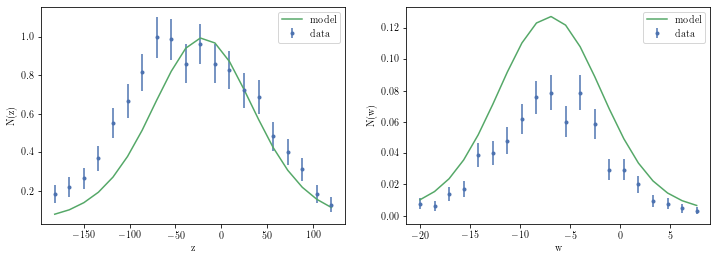

(52.85639686831882, -0.18210641043248188)

In [31]:
print(theta.shape)
zmod = mond.fz(zmid, theta)
wmod = mond.fw(wmid, theta)

# plot
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].errorbar(zmid, znum, yerr=zerr, fmt='.', label='data')
ax[0].plot(zmid, zmod, label='model')
ax[0].set_xlabel('z')
ax[0].set_ylabel('N(z)')
ax[0].legend()
ax[1].errorbar(wmid, wnum, yerr=werr, fmt='.', label='data')
ax[1].plot(wmid, wmod, label='model')
ax[1].set_xlabel('w')
ax[1].set_ylabel('N(w)')
ax[1].legend()
plt.show()
mond.log_prob(theta, zdata, wdata, locs, scales)

In [32]:
ndim = len(locs)+24
nwalkers = 2*ndim+2
ndim, nwalkers

(33, 68)

In [33]:
p0 = mond.generate_p0(nwalkers, locs, scales, kind=2)
p0.shape

(68, 33)

In [11]:
p0_flat = p0.reshape(-1, ndim)
mond.log_prob_par(p0_flat, zdata, wdata, locs, scales)

array([[ 4.34744695e+01, -1.03063859e+03, -9.87164117e+02],
       [ 4.26104693e+01, -3.75659042e+02, -3.33048573e+02],
       [ 3.51788396e+01, -7.05781212e+03, -7.02263328e+03],
       [ 4.46871218e+01, -5.39391214e+02, -4.94704092e+02],
       [ 4.43133628e+01, -2.28883902e+03, -2.24452566e+03],
       [ 4.05914353e+01, -1.42994828e+03, -1.38935685e+03],
       [ 3.80349543e+01, -1.47107161e+02, -1.09072206e+02],
       [ 4.22482920e+01, -2.63822829e+02, -2.21574537e+02],
       [ 3.54708842e+01, -2.31135246e+04, -2.30780537e+04],
       [ 4.19520926e+01, -1.03807731e+03, -9.96125221e+02],
       [ 4.46438530e+01, -2.10435484e+02, -1.65791632e+02],
       [ 3.53234881e+01, -4.22334990e+03, -4.18802641e+03],
       [ 4.15308345e+01, -1.01778666e+04, -1.01363357e+04],
       [ 4.14061593e+01, -8.59980916e+03, -8.55840300e+03],
       [ 4.33281224e+01, -2.73289913e+03, -2.68957101e+03],
       [ 4.08087694e+01, -8.17787330e+03, -8.13706453e+03],
       [ 4.09950456e+01, -1.61735344e+03

In [34]:
t0 = time()
chain = mond.mcmc(500, nwalkers, p0, zdata, wdata, locs, scales, dz=1, verbose=True, parallel=True)
print(time() - t0, "s")
chain.shape

4.492062091827393 s


(500, 68, 33)

In [13]:
calculate_probs(mond, chain, ndim, zdata, wdata, locs, scales, batch=100)

array([[   44.57174918,  -759.3396411 ,  -714.76789192],
       [   42.61046932,  -375.65904243,  -333.04857311],
       [   35.17883963, -7057.81211632, -7022.63327669],
       ...,
       [   45.5281166 ,   101.75112554,   147.27924215],
       [   46.14243919,    99.84962405,   145.99206324],
       [   40.5243795 ,    94.26271193,   134.78709144]])

100%|██████████| 10/10 [00:00<00:00, 43.50it/s]


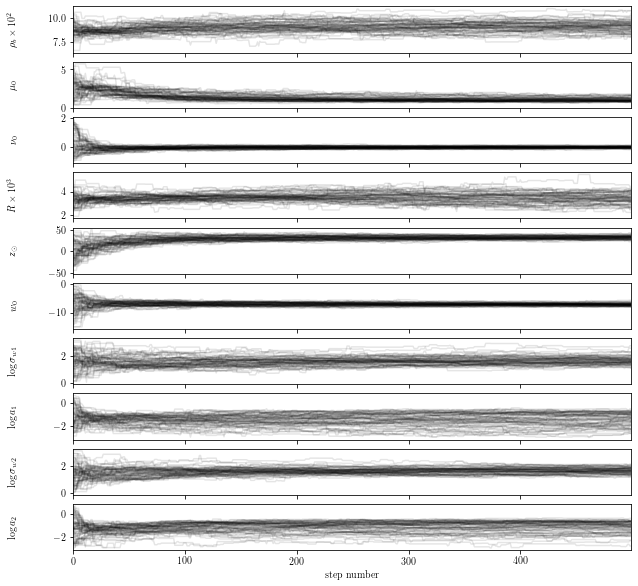

In [35]:
labels = [r'$\rho_b\times 10^2$', r'$\mu_0$', r'$\nu_0$', r'$R\times 10^3$', r'$z_{\odot}$', r'$w_0$', r'$\log \sigma_{w1}$', r'$\log a_1$', r'$\log \sigma_{w2}$', r'$\log a_2$']
labs = ['rhob', 'mu0', 'log_nu0', 'R', 'zsun', 'w0', 'log_sigmaw1', 'log_a1', 'log_sigmaw2', 'log_a2']
indexes = [12, 24, 25, 26, 27, 28, 29, 30, 31, 32]

params = get_params(chain, indexes, labs)
plot_chain(params, labels, figsize=(10,10))

In [36]:
p0_next = chain[-1, :, :]
t0 = time()
chain = mond.mcmc(2000, nwalkers, p0_next, zdata, wdata, locs, scales, dz=1, verbose=True, parallel=True)
print(time() - t0, "s")
chain.shape

15.08505129814148 s


(2000, 68, 33)

100%|██████████| 10/10 [00:00<00:00, 27.08it/s]


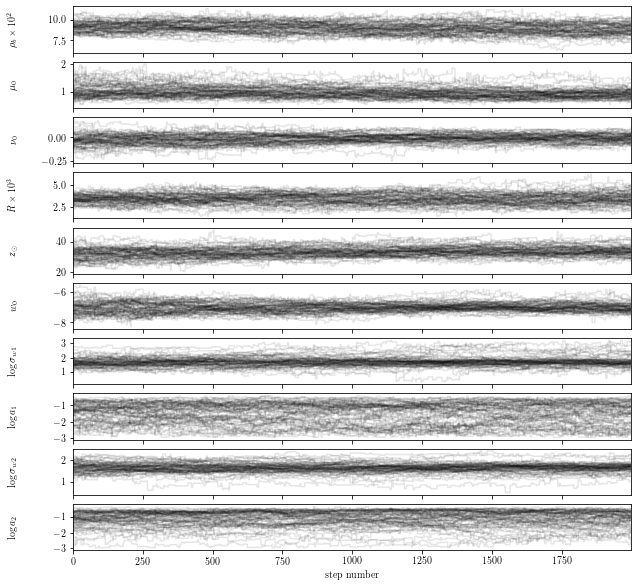

In [37]:
labels = [r'$\rho_b\times 10^2$', r'$\mu_0$', r'$\nu_0$', r'$R\times 10^3$', r'$z_{\odot}$', r'$w_0$', r'$\log \sigma_{w1}$', r'$\log a_1$', r'$\log \sigma_{w2}$', r'$\log a_2$']
labs = ['rhob', 'mu0', 'log_nu0', 'R', 'zsun', 'w0', 'log_sigmaw1', 'log_a1', 'log_sigmaw2', 'log_a2']
indexes = [12, 24, 25, 26, 27, 28, 29, 30, 31, 32]

params = get_params(chain, indexes, labs)
plot_chain(params, labels, figsize=(10,10))

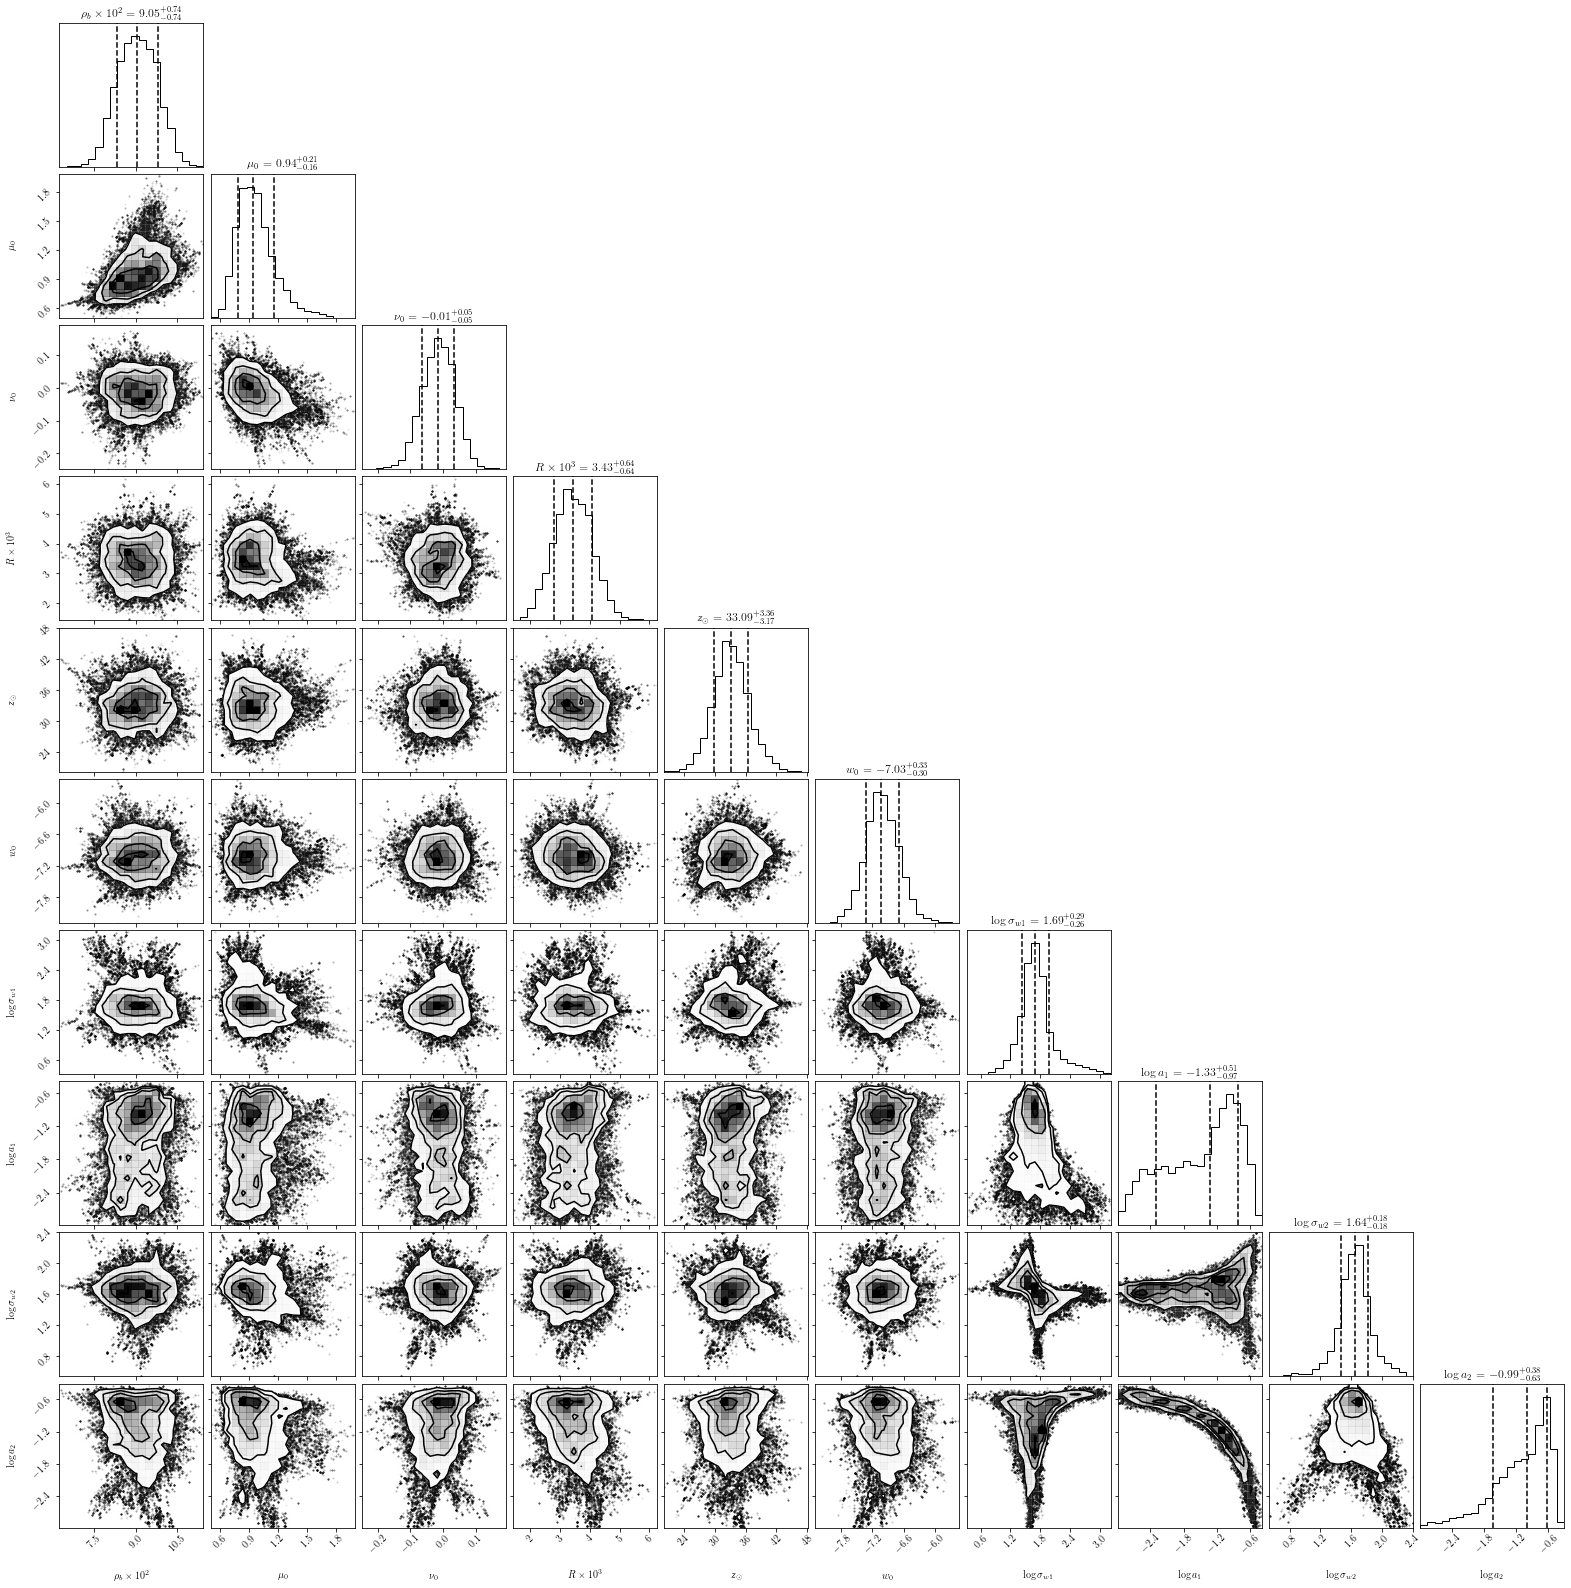

In [38]:
plot_corner(params, labels)

(136000, 33)


100%|██████████| 50000/50000 [00:35<00:00, 1400.84it/s]


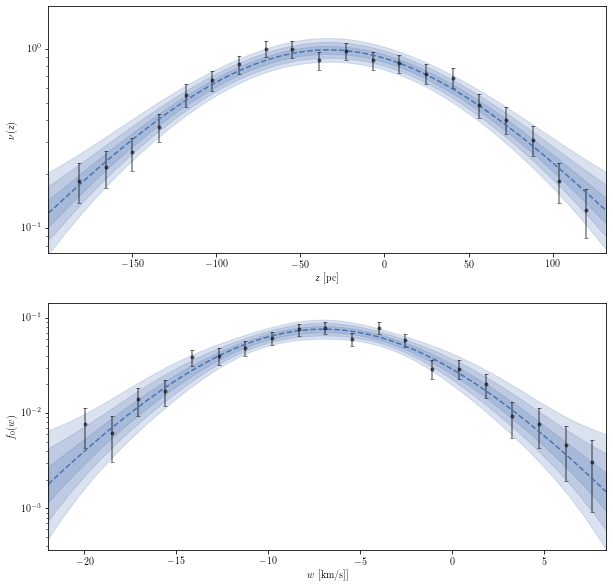

In [39]:
plot_fit(mond, zdata, wdata, chain, ndim)

In [40]:
probs = calculate_probs(mond, chain, ndim, zdata, wdata, locs, scales)

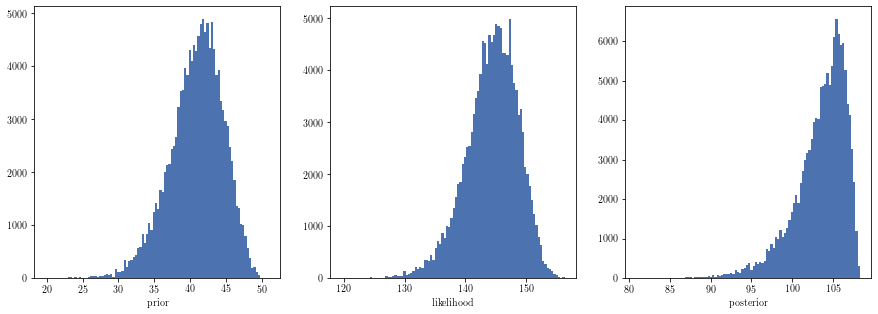

156.28114101163612

In [41]:
prior = probs[:, 0]
likelihood = probs[:, 2]
posterior = probs[:, 1]
# plot histogram of probabilities
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].hist(prior, bins=100)
axes[0].set_xlabel('prior')
axes[1].hist(likelihood, bins=100)
axes[1].set_xlabel('likelihood')
axes[2].hist(posterior, bins=100)
axes[2].set_xlabel('posterior')
plt.show()
likelihood.max()

The script for comparing also implemented in `script` folder.